# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**План исследования:**

* Ознакомиться с данными
* Разбить данные на выборки (Обучающая, валидационная, тестовая)
* Построить модель по методу случайного дерева, зафиксировать налучшие гиперпараметры
* Построить модель по методу случайного леса,зафиксировать налучшие гиперпараметры
* Построить модель по методу логистической регрессии
* Сравнить точность предсказания самых эффективных имплементаций каждого из методов, определить наилучший
* Проверить модели с наилучшими гиперпараметрами на тестовой выборке

## Откройте и изучите файл

In [17]:
# импорт библиотек и функций
import pandas as pd
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
#импорт файла
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
df['is_ultra'].mean()

0.30647168637212197

**Выводы:**
* Одна строка - один пользователь
* Целевой параметр - is_ultra
* Доля пользователей тарифа ultra - ~30%

## Разбейте данные на выборки

Разобью данные на  обучающую, валидационную и тестовую выборки в соотношении 3:1:1 со стратификацией по is_ultra.
Сначала разделю датасет на параметры и целевой параметр, затем разобью каждый из наборов на выборки.

In [7]:
df_features = df.drop(columns = 'is_ultra')
df_target = df['is_ultra']
print(df_features.head(),'\n','\n',df_target.head())

   calls  minutes  messages   mb_used
0   40.0   311.90      83.0  19915.42
1   85.0   516.75      56.0  22696.96
2   77.0   467.66      86.0  21060.45
3  106.0   745.53      81.0   8437.39
4   66.0   418.74       1.0  14502.75 
 
 0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64


In [8]:
features_train, features_test, target_train, target_test = train_test_split(df_features,
                                                                df_target,     
                                                                test_size=0.2,
                                                                random_state=1234, 
                                                                stratify=df_target
                                                                           )

Далее "отщипну" валидационную выборку от "обучающей".

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train,
                                                                target_train,     
                                                                test_size=0.25,
                                                                random_state=1234, 
                                                                stratify=target_train
                                                                             )

Проверю размеры выборок

In [10]:
sample_list = ['train','valid','test']
split_list = ['features', 'target']

for sample in sample_list:
    for split in split_list:
        print (f'Length of {split}_{sample}:', len(eval(''.join([split,'_',sample]))),'\n')

Length of features_train: 1928 

Length of target_train: 1928 

Length of features_valid: 643 

Length of target_valid: 643 

Length of features_test: 643 

Length of target_test: 643 



**Вывод:**
Данные разбиты в нужных соотношениях со стратификацией по is_ultra.

## Исследуйте модели

### Случайное дерево

Для начала построим модель по методу случайного дерева с переборкой глубины дерева, зафиксируем лучшие результаты.

  0%|          | 0/10 [00:00<?, ?it/s]

Best accuracy = 0.7993779160186625 at depth = 3


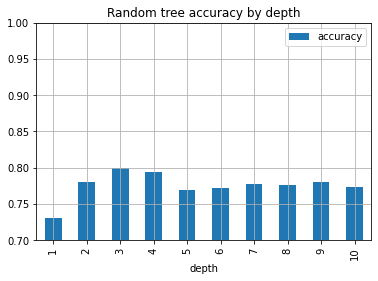

In [18]:
depth_accuracy = []
depth_list = []

# Осуществим перебор по глубине дерева

for depth in tqdm(range(1,11)):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 1234)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    depth_list.append(depth)
    depth_accuracy.append(accuracy)

# Сохраним параметры наилучшей модели 
tree_parameters = {'depth': depth_list[depth_accuracy.index(max(depth_accuracy))],\
                   'accuracy':max(depth_accuracy)}

# Сохраним саму наилучшую модель
model_tree = DecisionTreeClassifier(max_depth = tree_parameters['depth'], random_state = 1234)

# Выведем параметры модели для наглядности
print(f"Best accuracy = {tree_parameters['accuracy']} at depth = {tree_parameters['depth']}")

# Построим график
pd.DataFrame(list(zip(depth_list,depth_accuracy)),columns = ['depth','accuracy'])\
.plot(grid = True, x = 'depth', y = 'accuracy', kind = 'bar', ylim=(0.7,1),\
      title = 'Random tree accuracy by depth');

**Вывод:** 
При использовании метода случайного дерева наилучшая точность - 0,799 при глубине дерева = 3

### Случайный лес

Аналогично построим модель по методу случайного леса с переборкой количества эстиматоров и максимальной глубины дерева, зафиксируем лучшие результаты.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Best accuracy = 0.8133748055987559 at No. of estimators = 3 and max depth = 7


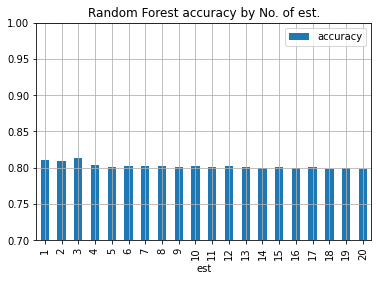

In [19]:
est_accuracy = []
est_list = []
est_accuracy_depth = []

# Осуществим перебор по количеству эстиматоров
for est in tqdm(range(1, 21)):
    depth_accuracy = []
    depth_list = []
    # Осуществим перебор по максимальной глубине дерева
    for depth in tqdm(range (1,10)):
        model = RandomForestClassifier(random_state=1234, n_estimators=est, max_depth = depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        depth_list.append(depth)
        depth_accuracy.append(result)
    est_list.append(est)
    est_accuracy.append(max(depth_accuracy))
    est_accuracy_depth.append(depth_list[depth_accuracy.index(max(depth_accuracy))])
    
# Сохраним параметры наилучшей модели
forest_parameters = {'est':est_list[est_accuracy.index(max(est_accuracy))],\
                     'accuracy':max(est_accuracy),\
                     'depth':est_accuracy_depth[est_accuracy.index(max(est_accuracy))]} 

# Сохраним модель с налиучшими параметрами
model_forest = RandomForestClassifier(random_state=1234, n_estimators=forest_parameters['est'],\
                                     max_depth=forest_parameters['depth'])

# Выведем параметры модели для наглядности
print(f"Best accuracy = {forest_parameters['accuracy']} at No. of estimators = {forest_parameters['est']}"\
      f" and max depth = {forest_parameters['depth']}")

# Построим график
pd.DataFrame(list(zip(est_list,est_accuracy)),columns=['est','accuracy'])\
.plot(grid = True, x = 'est', y = 'accuracy', kind = 'bar', ylim=(0.7,1),\
      title = 'Random Forest accuracy by No. of est.');

**Вывод:** При использовании метода случайного леса наилучшая точность - 0,813 при количестве эстиматоров = 3 и максимальной глубине дерева = 7

### Логистическая регрессия

Теперь построим модель по методу логистической регрессии, зафиксируем результаты.

  0%|          | 0/15 [00:00<?, ?it/s]

Best accuracy = 0.7371695178849145at No. of iterations = 100


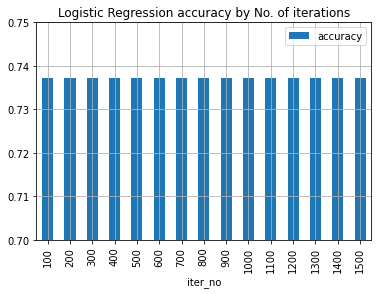

In [20]:
iter_accuracy = []
iter_list = []

# Осуществим перебор по количеству итераций с шагом 100
for iters in tqdm(range(100,1501,100)):
    model = LogisticRegression(random_state=1234, solver='lbfgs', max_iter = iters)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    iter_accuracy.append (result)
    iter_list.append (iters)

# Сохраним параметры наилучшей модели
regression_parameters = {'iter':iter_list[iter_accuracy.index(max(iter_accuracy))],\
                        'accuracy':max(iter_accuracy)}

# Выведем их для наглядности
print(f"Best accuracy = {regression_parameters['accuracy']}"\
      f"at No. of iterations = {regression_parameters['iter']}")

#Сохраним наилучшую модель 
model_regression = LogisticRegression(random_state=1234, solver='lbfgs',
                                      max_iter = regression_parameters['iter'])

#Построим график
pd.DataFrame(list(zip(iter_list,iter_accuracy)),columns = ['iter_no','accuracy'])\
.plot(grid = True, x = 'iter_no', y = 'accuracy', kind = 'bar', ylim=(0.7,0.75),\
      title = 'Logistic Regression accuracy by No. of iterations');

**Вывод:** При использовании метода логистической регрессии наилучшая точность - 0,737, количество итераций в интервале от 100 до 1500 не влияет на точность модели.

**Общий вывод:** Наилучшие результаты достигаются при использовании модели случайного леса. Сохранены все оптимизированные модели.

## Проверьте модель на тестовой выборке

Проверим наилучшие имплементации каждого из методов на тестовой выборке.

,method,accuracy
0,tree,0.774495
1,forest,0.777605
2,regression,0.738725


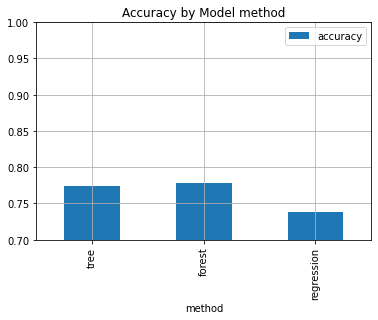

In [21]:
method_list = ['tree','forest','regression']
method_accuracy = []

# Проверим наилучшие из моделей на тестовой выборке
for method in method_list:
    model = eval(''.join(['model_',method]))
    model.fit(features_train, target_train)
    predict = model.predict(features_test)
    accuracy = accuracy_score(target_test, predict)
    method_accuracy.append(accuracy)

# Посмотрим, какая из моделей наиболее точная, визуализируем   
method_comp = pd.DataFrame(list(zip(method_list,method_accuracy)),columns = ['method','accuracy'])
method_comp.plot(grid = True, x = 'method', y = 'accuracy', kind = 'bar', ylim=(0.7,1),\
                 title = 'Accuracy by Model method')
method_comp

**Выводы:**  
Налучшие показатели на тестовой выборке показала модель случайного леса (точность - 0,778).  
Для предсказаний стоит пользоваться моделью случайного леса с параметрами:
* Количество эстиматоров = 3
* Максимальная глубина дерева = 7

## Проверка моделей на адекватность.

Успешность решения задачи бинарной классификации можно оценить с помощью метрик чувствительности, специфичности и точности.
Эти метрики высчитываются из оценок истинных и ложных положительных и негативных результатов классификации.  

Построим матрицы запутанности для каждой модели.

In [11]:
for method in method_list:
    model = eval(''.join(['model_',method]))
    model.fit(features_train, target_train)
    predict = model.predict(features_test)
    print(method)
    print(confusion_matrix(target_test, predict),'\n')

tree
[[403  43]
 [102  95]] 

forest
[[406  40]
 [103  94]] 

regression
[[431  15]
 [153  44]] 



Каждая из моделей склонна к ложнопозитивной оценке - все обладают достаточно низкой чувствительностью.
При этом вероятность пропустить истинно положительный результат минимальна: будет высокая оценка precision.  

F1-score, который может оценить адекватность модели в целом, в каждом случае будет невелик.  
В подтверждение этого построю classification_report для каждой модели.

In [12]:
for method in method_list:
    model = eval(''.join(['model_',method]))
    model.fit(features_train, target_train)
    predict = model.predict(features_test)
    print(method)
    print(classification_report(target_test, predict),'\n')

tree
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       446
           1       0.69      0.48      0.57       197

    accuracy                           0.77       643
   macro avg       0.74      0.69      0.71       643
weighted avg       0.76      0.77      0.76       643
 

forest
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       446
           1       0.70      0.48      0.57       197

    accuracy                           0.78       643
   macro avg       0.75      0.69      0.71       643
weighted avg       0.77      0.78      0.76       643
 

regression
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       446
           1       0.75      0.22      0.34       197

    accuracy                           0.74       643
   macro avg       0.74      0.59      0.59       643
weighted avg       0.74      0.74      0.69    

**Вывод:**  
Адекватность модели на невысоком уровне. Причина, возможно, в выборке - она, вероятно, не очень сбалансирована.

## Общий вывод:
* Данные были оценены и разбиты на выборки со стратификацией по тарифу.
* Были построены предиктивные модели разных видов с подбором оптимальных гиперпараметров.
* Наилучшие модели были проверены на тестовой выборке.  
Определена лучшая - модель случайного леса с 3 эстиматорами и наибольшей глубиной дерева = 7. Точность модели на тестовой выборке составила 0,778
* Проанализированы прочие метрики адекватности модели. Признана невысокой - вероятно, из-за несбалансированной выборки.